In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering
import tensorflow as tf
from tensorflow import keras


In [2]:
def loadData():
    Data = pd.read_csv("UsedCars.csv", na_values= 'null bhp')
    return Data

Data = loadData()
Data.info()
Data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5876 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


Unnamed: 0         Year  Kilometers_Driven        Seats        Price
count  6019.000000  6019.000000       6.019000e+03  5977.000000  6019.000000
mean   3009.000000  2013.358199       5.873838e+04     5.278735     9.479468
std    1737.679967     3.269742       9.126884e+04     0.808840    11.187917
min       0.000000  1998.000000       1.710000e+02     0.000000     0.440000
25%    1504.500000  2011.000000       3.400000e+04     5.000000     3.500000
50%    3009.000000  2014.000000       5.300000e+04     5.000000     5.640000
75%    4513.500000  2016.000000       7.300000e+04     5.000000     9.950000
max    6018.000000  2019.000000       6.500000e+06    10.000000   160.000000

In [3]:
def featureEngineerData(Data):
    threshold = 0.7
    Data = Data[Data.columns[Data.isnull().mean() < threshold]]
    Data.dropna()
    
    # Manufacturer of car
    Data['Manufacturer'] = Data.Name.str.split(' ').map(lambda x: x[0])
    encodedCols = pd.get_dummies(Data['Manufacturer'])
    Data = Data.join(encodedCols)

    # Dropping units, assumption : km/kg and kmpl are equivalent units for comparison
    Data = Data[pd.notnull(Data.Mileage)]
    Data['Mileage'] = Data.Mileage.str.split(' ').map(lambda x: x[0])
    Data['Mileage'] = Data['Mileage'].astype(float)
    Data['Mileage'] = Data['Mileage'].replace(0, Data['Mileage'].median())

    # Column = "Fuel_Type"
    encodedCols = pd.get_dummies(Data['Fuel_Type'])
    Data = Data.join(encodedCols)

    # Column = "Transmission"
    Data['Transmission'] = Data['Transmission'].map( {'Manual': 0, 'Automatic': 1} ).astype(int)

    # Column = "Owner Type"
    Data['Owner_Type'] = Data['Owner_Type'].map( {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4} ).astype(int)

    # Column = "Engine"
    Data['Engine'].fillna('0.0', inplace= True)
    Data['Engine'] = Data.Engine.str.split(' ').map(lambda x: x[0])
    Data['Engine'] = Data['Engine'].astype(float)
    Data['Engine'] = Data['Engine'].replace(0, Data['Engine'].median())

    # Column = "Power"
    Data['Power'].fillna('0.0', inplace= True)
    Data['Power'] = Data.Power.str.split(' ').map(lambda x: x[0])
    Data['Power'] = Data['Power'].astype(float)
    Data['Power'] = Data['Power'].replace(0, Data['Power'].median())

    # Column = "Seats"
    Data['Seats'].fillna(Data['Seats'].median(), inplace= True)
    Data['Seats'] = Data['Seats'].replace(0, Data['Seats'].median())

    # Column = "Location"
    encodedCols = pd.get_dummies(Data['Location'])
    Data = Data.join(encodedCols)

    # Column = "Kilometers_Driven"
    factor = 3
    upper_lim = Data['Kilometers_Driven'].mean() + Data['Kilometers_Driven'].std()*factor
    lower_lim = Data['Kilometers_Driven'].mean() - Data['Kilometers_Driven'].std()*factor
    Data = Data[(Data['Kilometers_Driven'] < upper_lim) & (Data['Kilometers_Driven'] > lower_lim)]

    return Data
Data = featureEngineerData(Data)

In [4]:
Data.describe()

Unnamed: 0         Year  Kilometers_Driven  Transmission   Owner_Type  \
count  6010.000000  6010.000000        6010.000000   6010.000000  6010.000000   
mean   3009.405824  2013.357903       57143.479368      0.285358     1.203161   
std    1737.840166     3.270904       33775.774691      0.451622     0.456630   
min       0.000000  1998.000000         171.000000      0.000000     1.000000   
25%    1504.250000  2011.000000       34000.000000      0.000000     1.000000   
50%    3009.500000  2014.000000       53000.000000      0.000000     1.000000   
75%    4514.750000  2016.000000       73000.000000      1.000000     1.000000   
max    6018.000000  2019.000000      300000.000000      1.000000     4.000000   

           Mileage       Engine        Power        Seats        Price  ...  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  ...   
mean     18.339972  1620.558569   112.723542     5.278037     9.472150  ...   
std       4.153911   599.400476    53.328796     0.804009    11.172289  ...   
min       6.400000   624.000000    34.200000     2.000000     0.440000  ...   
25%      15.400000  1198.000000    78.000000     5.000000     3.500000  ...   
50%      18.150000  1493.000000    91.100000     5.000000     5.635000  ...   
75%      21.100000  1975.750000   138.030000     5.000000     9.950000  ...   
max      33.540000  5998.000000   560.000000    10.000000   160.000000  ...   

         Bangalore      Chennai   Coimbatore        Delhi    Hyderabad  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000   
mean      0.059401     0.081364     0.105824     0.092180     0.123461   
std       0.236393     0.273417     0.307637     0.289304     0.328993   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Jaipur        Kochi      Kolkata       Mumbai         Pune  
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  
mean      0.068719     0.108319     0.088686     0.131281     0.103494  
std       0.252996     0.310809     0.284313     0.337736     0.304629  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 56 columns]

In [5]:
Data.head()

Unnamed: 0                              Name    Location  Year  \
0           0            Maruti Wagon R LXI CNG      Mumbai  2010   
1           1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015   
2           2                      Honda Jazz V     Chennai  2011   
3           3                 Maruti Ertiga VDI     Chennai  2012   
4           4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013   

   Kilometers_Driven Fuel_Type  Transmission  Owner_Type  Mileage  Engine  \
0              72000       CNG             0           1    26.60   998.0   
1              41000    Diesel             0           1    19.67  1582.0   
2              46000    Petrol             0           1    18.20  1199.0   
3              87000    Diesel             0           1    20.77  1248.0   
4              40670    Diesel             1           2    15.20  1968.0   

   ...  Bangalore  Chennai  Coimbatore Delhi  Hyderabad  Jaipur  Kochi  \
0  ...          0        0           0     0          0       0      0   
1  ...          0        0           0     0          0       0      0   
2  ...          0        1           0     0          0       0      0   
3  ...          0        1           0     0          0       0      0   
4  ...          0        0           1     0          0       0      0   

   Kolkata  Mumbai  Pune  
0        0       1     0  
1        0       0     1  
2        0       0     0  
3        0       0     0  
4        0       0     0  

[5 rows x 60 columns]

In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6010 entries, 0 to 6018
Data columns (total 60 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6010 non-null   int64  
 1   Name               6010 non-null   object 
 2   Location           6010 non-null   object 
 3   Year               6010 non-null   int64  
 4   Kilometers_Driven  6010 non-null   int64  
 5   Fuel_Type          6010 non-null   object 
 6   Transmission       6010 non-null   int32  
 7   Owner_Type         6010 non-null   int32  
 8   Mileage            6010 non-null   float64
 9   Engine             6010 non-null   float64
 10  Power              6010 non-null   float64
 11  Seats              6010 non-null   float64
 12  Price              6010 non-null   float64
 13  Manufacturer       6010 non-null   object 
 14  Ambassador         6010 non-null   uint8  
 15  Audi               6010 non-null   uint8  
 16  BMW                6010 

Text(0, 0.5, 'Number of cars')

<Figure size 432x288 with 0 Axes>

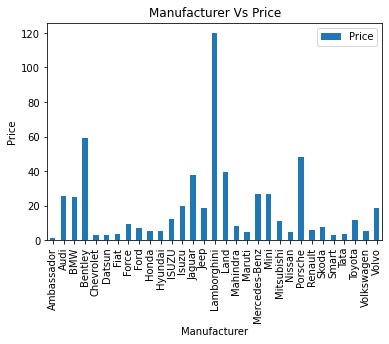

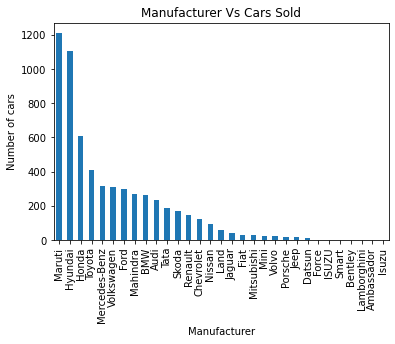

In [7]:
# Column : "Manufacturer"

# What are the average resale prices of cars from different manufacturers?
plt.figure()
Ftrs = Data[['Manufacturer', 'Price']].groupby(['Manufacturer']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Manufacturer Vs Price")
plt.xlabel("Manufacturer")
plt.ylabel("Price")

# Which company produces how many cars?
plt.figure()
Ftrs = Data.Manufacturer.value_counts()
Ftrs.plot(kind = 'bar')
plt.title("Manufacturer Vs Cars Sold")
plt.xlabel("Manufacturer")
plt.ylabel("Number of cars")

Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

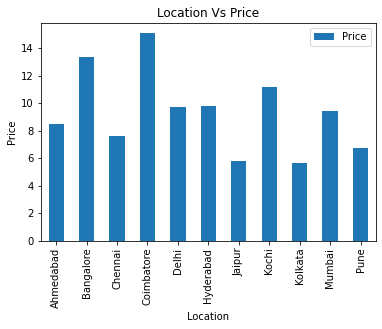

In [8]:
# Column : "Location"

# What are the average price of the cars sold in a particular region/city ?
plt.figure()
Ftrs = Data[['Location', 'Price']].groupby(['Location']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Location Vs Price")
plt.xlabel("Location")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

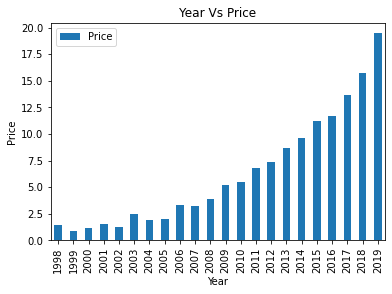

In [9]:
# Column = "Year"

# How does price depreciate with the age of the car ?
plt.figure()
Ftrs = Data[['Year', 'Price']].groupby(['Year']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Year Vs Price")
plt.xlabel("Year")
plt.ylabel("Price")

# We can see that the price decreases somewhat exponentially with how old the car is.

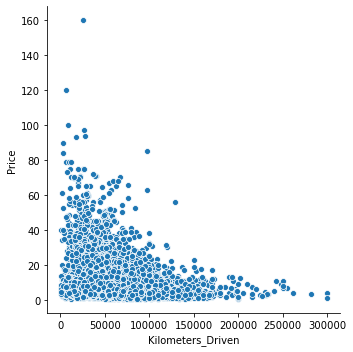

In [10]:
# Column = "Kilometers_Driven"

# how does the price of the car vary with the number of kilometers it's been driven??
# Observation : we see decrease in price of cars with the increase in the kilometers they have been driven for
sns.relplot(
    data= Data, x="Kilometers_Driven", y="Price",  kind="scatter", 
)

In [11]:
Data.describe()

Unnamed: 0         Year  Kilometers_Driven  Transmission   Owner_Type  \
count  6010.000000  6010.000000        6010.000000   6010.000000  6010.000000   
mean   3009.405824  2013.357903       57143.479368      0.285358     1.203161   
std    1737.840166     3.270904       33775.774691      0.451622     0.456630   
min       0.000000  1998.000000         171.000000      0.000000     1.000000   
25%    1504.250000  2011.000000       34000.000000      0.000000     1.000000   
50%    3009.500000  2014.000000       53000.000000      0.000000     1.000000   
75%    4514.750000  2016.000000       73000.000000      1.000000     1.000000   
max    6018.000000  2019.000000      300000.000000      1.000000     4.000000   

           Mileage       Engine        Power        Seats        Price  ...  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  ...   
mean     18.339972  1620.558569   112.723542     5.278037     9.472150  ...   
std       4.153911   599.400476    53.328796     0.804009    11.172289  ...   
min       6.400000   624.000000    34.200000     2.000000     0.440000  ...   
25%      15.400000  1198.000000    78.000000     5.000000     3.500000  ...   
50%      18.150000  1493.000000    91.100000     5.000000     5.635000  ...   
75%      21.100000  1975.750000   138.030000     5.000000     9.950000  ...   
max      33.540000  5998.000000   560.000000    10.000000   160.000000  ...   

         Bangalore      Chennai   Coimbatore        Delhi    Hyderabad  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000   
mean      0.059401     0.081364     0.105824     0.092180     0.123461   
std       0.236393     0.273417     0.307637     0.289304     0.328993   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Jaipur        Kochi      Kolkata       Mumbai         Pune  
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  
mean      0.068719     0.108319     0.088686     0.131281     0.103494  
std       0.252996     0.310809     0.284313     0.337736     0.304629  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 56 columns]

<Figure size 432x288 with 0 Axes>

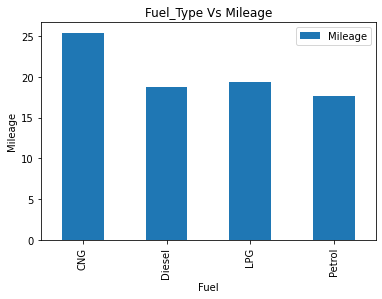

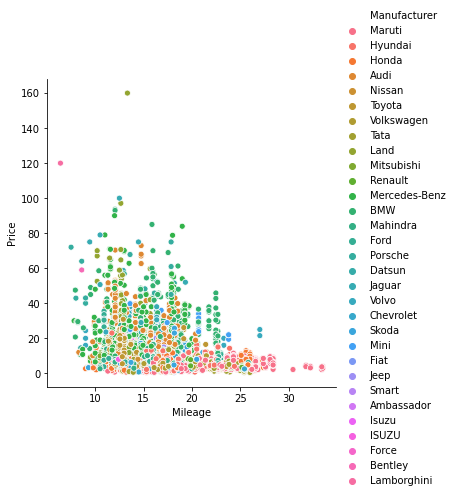

In [12]:
# Column = "Mileage"

# What type of fuel gives better mileage? / Do petrol cars have lesser mileage?
# Obs : CNG gives much higher mileage than Petrol, Diesel and LPG
plt.figure()
Ftrs = Data[['Fuel_Type', 'Mileage']].groupby(['Fuel_Type']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Fuel_Type Vs Mileage")
plt.xlabel("Fuel")
plt.ylabel("Mileage")

# Does the mileage of the car influence the price of the car??
# obs = 
sns.relplot(
    data= Data, x="Mileage", y="Price", hue="Manufacturer", kind="scatter", 
    facet_kws={"legend_out": True}
)

In [13]:
Data.describe()

Unnamed: 0         Year  Kilometers_Driven  Transmission   Owner_Type  \
count  6010.000000  6010.000000        6010.000000   6010.000000  6010.000000   
mean   3009.405824  2013.357903       57143.479368      0.285358     1.203161   
std    1737.840166     3.270904       33775.774691      0.451622     0.456630   
min       0.000000  1998.000000         171.000000      0.000000     1.000000   
25%    1504.250000  2011.000000       34000.000000      0.000000     1.000000   
50%    3009.500000  2014.000000       53000.000000      0.000000     1.000000   
75%    4514.750000  2016.000000       73000.000000      1.000000     1.000000   
max    6018.000000  2019.000000      300000.000000      1.000000     4.000000   

           Mileage       Engine        Power        Seats        Price  ...  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  ...   
mean     18.339972  1620.558569   112.723542     5.278037     9.472150  ...   
std       4.153911   599.400476    53.328796     0.804009    11.172289  ...   
min       6.400000   624.000000    34.200000     2.000000     0.440000  ...   
25%      15.400000  1198.000000    78.000000     5.000000     3.500000  ...   
50%      18.150000  1493.000000    91.100000     5.000000     5.635000  ...   
75%      21.100000  1975.750000   138.030000     5.000000     9.950000  ...   
max      33.540000  5998.000000   560.000000    10.000000   160.000000  ...   

         Bangalore      Chennai   Coimbatore        Delhi    Hyderabad  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000   
mean      0.059401     0.081364     0.105824     0.092180     0.123461   
std       0.236393     0.273417     0.307637     0.289304     0.328993   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Jaipur        Kochi      Kolkata       Mumbai         Pune  
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  
mean      0.068719     0.108319     0.088686     0.131281     0.103494  
std       0.252996     0.310809     0.284313     0.337736     0.304629  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 56 columns]

Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

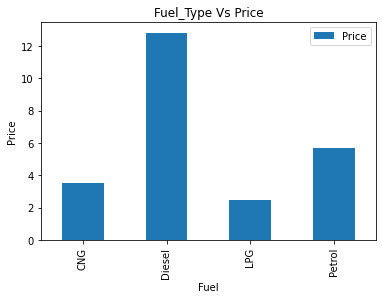

In [14]:
# Column = "Fuel_Type"

# which fuel_type cars have better resale value??
# Observation: Diesel cars have exceptionally higher resale value compared to other fuel types
plt.figure()
Ftrs = Data[['Fuel_Type', 'Price']].groupby(['Fuel_Type']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Fuel_Type Vs Price")
plt.xlabel("Fuel")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

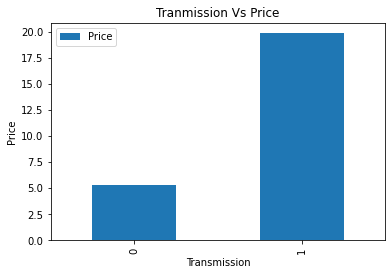

In [15]:
# Column = "Transmission"

# transmission vs manual transmission cars wrt price
# Observation : Automatic cars are much more expensive than manual transmission cars.
plt.figure()
Ftrs = Data[['Transmission', 'Price']].groupby(['Transmission']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Tranmission Vs Price")
plt.xlabel("Transmission")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

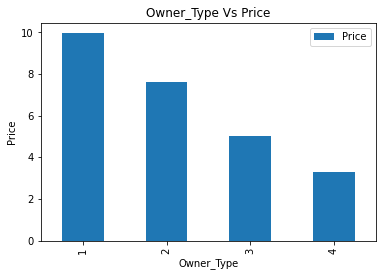

In [16]:
# Column = "Owner_Type"

# How does the price depreciate with increase in the number of previous owners of the car??
# Observation: Constant decrease in value of car with increasing number of owners
plt.figure()
Ftrs = Data[['Owner_Type', 'Price']].groupby(['Owner_Type']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Owner_Type Vs Price")
plt.xlabel("Owner_Type")
plt.ylabel("Price")

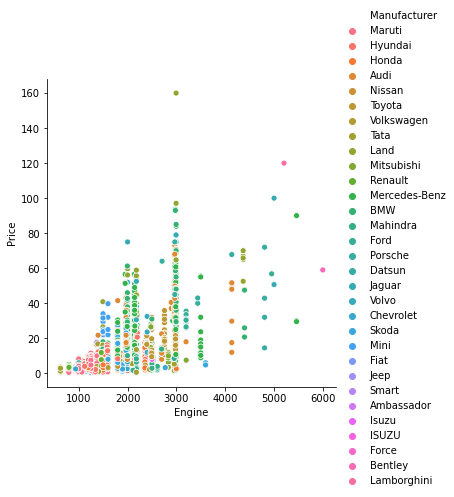

In [17]:
# Column = "Engine"

# Engine Size vs Price ?
sns.relplot(
    data= Data, x="Engine", y="Price", hue="Manufacturer", kind="scatter", 
    facet_kws={"legend_out": True}
)

In [18]:
Data.describe()

Unnamed: 0         Year  Kilometers_Driven  Transmission   Owner_Type  \
count  6010.000000  6010.000000        6010.000000   6010.000000  6010.000000   
mean   3009.405824  2013.357903       57143.479368      0.285358     1.203161   
std    1737.840166     3.270904       33775.774691      0.451622     0.456630   
min       0.000000  1998.000000         171.000000      0.000000     1.000000   
25%    1504.250000  2011.000000       34000.000000      0.000000     1.000000   
50%    3009.500000  2014.000000       53000.000000      0.000000     1.000000   
75%    4514.750000  2016.000000       73000.000000      1.000000     1.000000   
max    6018.000000  2019.000000      300000.000000      1.000000     4.000000   

           Mileage       Engine        Power        Seats        Price  ...  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  ...   
mean     18.339972  1620.558569   112.723542     5.278037     9.472150  ...   
std       4.153911   599.400476    53.328796     0.804009    11.172289  ...   
min       6.400000   624.000000    34.200000     2.000000     0.440000  ...   
25%      15.400000  1198.000000    78.000000     5.000000     3.500000  ...   
50%      18.150000  1493.000000    91.100000     5.000000     5.635000  ...   
75%      21.100000  1975.750000   138.030000     5.000000     9.950000  ...   
max      33.540000  5998.000000   560.000000    10.000000   160.000000  ...   

         Bangalore      Chennai   Coimbatore        Delhi    Hyderabad  \
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000   
mean      0.059401     0.081364     0.105824     0.092180     0.123461   
std       0.236393     0.273417     0.307637     0.289304     0.328993   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Jaipur        Kochi      Kolkata       Mumbai         Pune  
count  6010.000000  6010.000000  6010.000000  6010.000000  6010.000000  
mean      0.068719     0.108319     0.088686     0.131281     0.103494  
std       0.252996     0.310809     0.284313     0.337736     0.304629  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 56 columns]

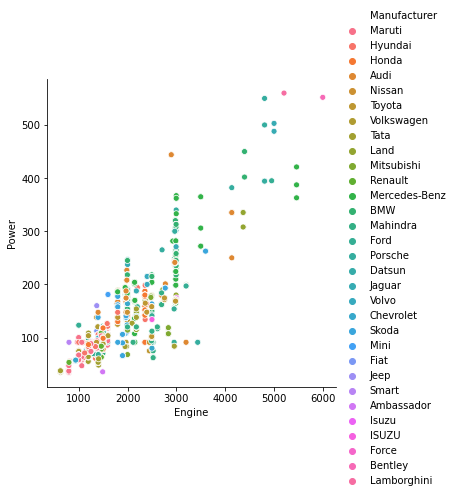

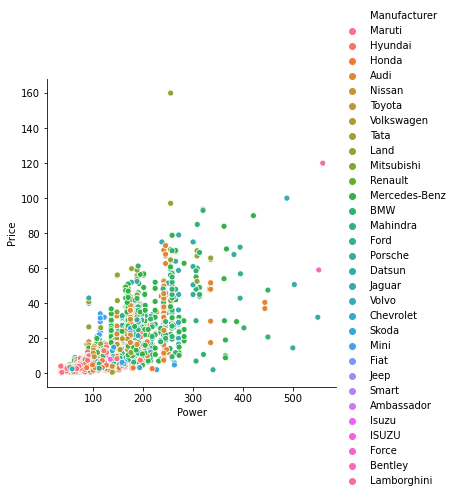

In [19]:
# Column = "Power"

# Power Vs Engine ?
# Power varies quite linearly with engine size
sns.relplot(
    data=Data, x="Engine", y="Power", hue="Manufacturer", kind="scatter", 
    facet_kws={"legend_out": True}
)

# Power Vs Price ?
# Price increases constantly with Power
sns.relplot(
    data=Data, x="Power", y="Price", hue="Manufacturer", kind="scatter", 
    facet_kws={"legend_out": True}
)


Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

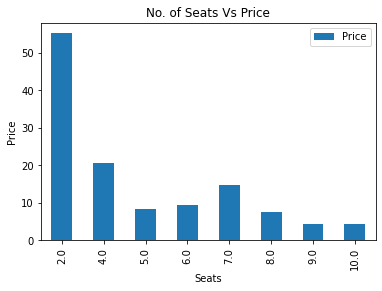

In [20]:
# Column = "Seats"

# Car Size vs resale value?
plt.figure()
Ftrs = Data[['Seats', 'Price']].groupby(['Seats']).mean()
Ftrs.plot(kind= 'bar')
plt.title("No. of Seats Vs Price")
plt.xlabel("Seats")
plt.ylabel("Price")

# Peak for 2 seater cars would refer to expensive sportscars belonging to that category

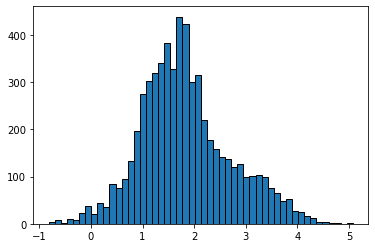

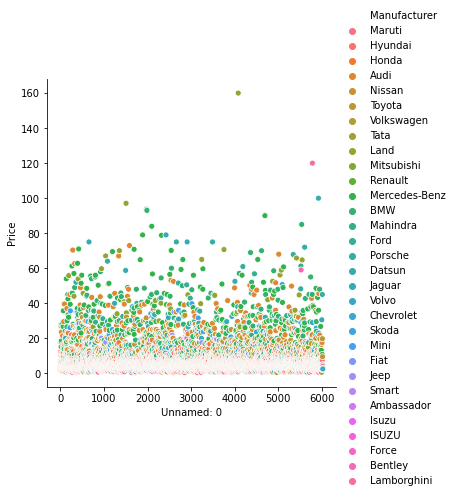

In [21]:
# Column = "Price"

plt.figure()
plt.hist(np.log(Data["Price"]), bins=50, edgecolor='black')


sns.relplot(
    data=Data, x="Unnamed: 0", y="Price", hue="Manufacturer", kind="scatter", 
    facet_kws={"legend_out": True}
)


In [22]:
def cleanPrepData(Data):
    Data.drop(columns = ['Unnamed: 0', 'Fuel_Type','Name','Manufacturer','Location'], inplace= True) # FuelType
    Data['Price'] = np.log(Data['Price'])

    return Data

trainData = Data
trainData = cleanPrepData(trainData)


upperLim = trainData['Price'].quantile(0.95)
lowerLim = trainData['Price'].quantile(0.05)
trainData = trainData[(trainData['Price'] < upperLim)&(trainData['Price']>lowerLim)]

In [23]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5406 entries, 0 to 6018
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               5406 non-null   int64  
 1   Kilometers_Driven  5406 non-null   int64  
 2   Transmission       5406 non-null   int32  
 3   Owner_Type         5406 non-null   int32  
 4   Mileage            5406 non-null   float64
 5   Engine             5406 non-null   float64
 6   Power              5406 non-null   float64
 7   Seats              5406 non-null   float64
 8   Price              5406 non-null   float64
 9   Ambassador         5406 non-null   uint8  
 10  Audi               5406 non-null   uint8  
 11  BMW                5406 non-null   uint8  
 12  Bentley            5406 non-null   uint8  
 13  Chevrolet          5406 non-null   uint8  
 14  Datsun             5406 non-null   uint8  
 15  Fiat               5406 non-null   uint8  
 16  Force              5406 

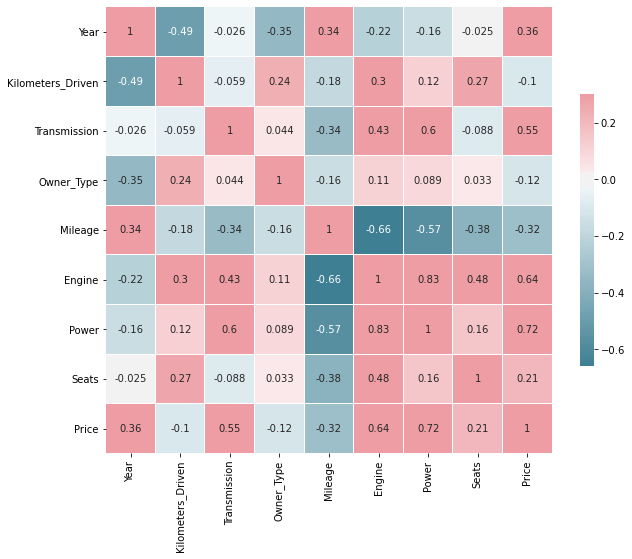

In [24]:
corr_mat = trainData.iloc[:, 0:9].corr()
plt.figure(figsize = (10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.2, cbar_kws={"shrink": .5} , annot=True)

In [25]:
print(trainData.shape)
trainData.info()

(5406, 55)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5406 entries, 0 to 6018
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               5406 non-null   int64  
 1   Kilometers_Driven  5406 non-null   int64  
 2   Transmission       5406 non-null   int32  
 3   Owner_Type         5406 non-null   int32  
 4   Mileage            5406 non-null   float64
 5   Engine             5406 non-null   float64
 6   Power              5406 non-null   float64
 7   Seats              5406 non-null   float64
 8   Price              5406 non-null   float64
 9   Ambassador         5406 non-null   uint8  
 10  Audi               5406 non-null   uint8  
 11  BMW                5406 non-null   uint8  
 12  Bentley            5406 non-null   uint8  
 13  Chevrolet          5406 non-null   uint8  
 14  Datsun             5406 non-null   uint8  
 15  Fiat               5406 non-null   uint8  
 16  Force        

In [26]:
trainData.head()

Year  Kilometers_Driven  Transmission  Owner_Type  Mileage  Engine   Power  \
0  2010              72000             0           1    26.60   998.0   58.16   
1  2015              41000             0           1    19.67  1582.0  126.20   
2  2011              46000             0           1    18.20  1199.0   88.70   
3  2012              87000             0           1    20.77  1248.0   88.76   
4  2013              40670             1           2    15.20  1968.0  140.80   

   Seats     Price  Ambassador  ...  Bangalore  Chennai  Coimbatore  Delhi  \
0    5.0  0.559616           0  ...          0        0           0      0   
1    5.0  2.525729           0  ...          0        0           0      0   
2    5.0  1.504077           0  ...          0        1           0      0   
3    7.0  1.791759           0  ...          0        1           0      0   
4    5.0  2.875822           0  ...          0        0           1      0   

   Hyderabad  Jaipur  Kochi  Kolkata  Mumbai  Pune  
0          0       0      0        0       1     0  
1          0       0      0        0       0     1  
2          0       0      0        0       0     0  
3          0       0      0        0       0     0  
4          0       0      0        0       0     0  

[5 rows x 55 columns]

In [27]:
# generating X and y sets
def genTrainingSets(trainData):
    X = trainData.drop(columns = ['Price'])
    y = trainData['Price']
    return X, y

X_train, y_train = genTrainingSets(trainData)

In [28]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [29]:
# evaluating linear model

modelLinear = Ridge(fit_intercept= True, alpha = 0.006)
cv_scores = cross_val_score(modelLinear, X_train, y_train, cv = 5, scoring= 'neg_mean_squared_error')
modelLinear.fit(X_train, y_train)
cv_scores.mean()

-0.0501215179036774

In [30]:
def NNModel():
    modelNN = tf.keras.Sequential()

    modelNN.add(tf.keras.Input(shape = 54))
    modelNN.add(tf.keras.layers.BatchNormalization())

    modelNN.add(tf.keras.layers.Dense(units= 32, kernel_initializer = 'normal', activation = 'relu'))
    modelNN.add(tf.keras.layers.Dropout(0.2))

    modelNN.add(tf.keras.layers.Dense(units= 16, kernel_initializer = 'normal', activation = 'relu', activity_regularizer= tf.keras.regularizers.l2(0.01)))

    modelNN.add(tf.keras.layers.Dense(units = 1, kernel_initializer = 'normal', activity_regularizer= tf.keras.regularizers.l2(0.09)))

    opt = tf.keras.optimizers.SGD(0.001)
    modelNN.compile(loss='mse', optimizer= opt, metrics=['mse'])

    return modelNN

In [31]:
modelNN = NNModel()
modelNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 54)                216       
_________________________________________________________________
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,521
Trainable params: 2,413
Non-trainable params: 108
_________________________________________________________________


In [32]:
keras_history = modelNN.fit(X_train,  y_train , batch_size= 16, epochs= 40, validation_split = 0.3)

Train on 3784 samples, validate on 1622 samples
Epoch 1/40
3784/3784 [==============================] - 2s 419us/sample - loss: 2.5359 - mse: 2.5179 - val_loss: 1.0186 - val_mse: 0.7527
Epoch 2/40
3784/3784 [==============================] - 1s 150us/sample - loss: 1.2674 - mse: 1.1804 - val_loss: 0.8848 - val_mse: 0.7392
Epoch 3/40
3784/3784 [==============================] - 1s 149us/sample - loss: 0.8316 - mse: 0.6696 - val_loss: 0.7069 - val_mse: 0.5047
Epoch 4/40
3784/3784 [==============================] - 1s 149us/sample - loss: 0.6947 - mse: 0.4792 - val_loss: 0.6355 - val_mse: 0.3906
Epoch 5/40
3784/3784 [==============================] - 1s 145us/sample - loss: 0.6373 - mse: 0.3909 - val_loss: 0.5954 - val_mse: 0.3273
Epoch 6/40
3784/3784 [==============================] - 1s 139us/sample - loss: 0.5997 - mse: 0.3380 - val_loss: 0.5606 - val_mse: 0.2800
Epoch 7/40
3784/3784 [==============================] - 1s 139us/sample - loss: 0.5704 - mse: 0.3001 - val_loss: 0.5303 - va

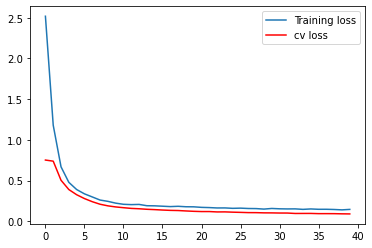

In [33]:
plt.plot(keras_history.history['mse'], label='Training loss')
plt.plot(keras_history.history['val_mse'], color='red', label='cv loss')
plt.legend()

In [34]:
# function to get predictions from neural network

def NNModelPredictions(X_test):
    modelNN = NNModel()
    keras_history = modelNN.fit(X_train, y_train , batch_size= 16, epochs= 40)
    predictions = modelNN.predict(X_test)
    return predictions

In [35]:
X = pd.DataFrame(X_train)
X['Price'] = y_train
X.drop(X.iloc[:, 8:54], inplace= True, axis=1)

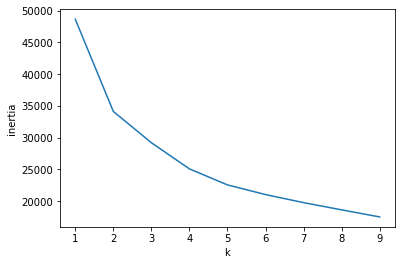

In [36]:
k_range = range(1,10)
scores = []

scaler= StandardScaler()


for k in k_range:
    kmc = KMeans(n_clusters = k)
    kmc.fit(scaler.fit_transform(X))
    scores.append(kmc.inertia_)

    
plt.figure()
plt.xlabel('k')
plt.ylabel('inertia')
plt.plot(k_range, scores)



In [37]:
# N_clusters = 3 seems like a good choice. (Elbow at about n = 3)

def ClusteringModel(trainData, n):
    model_clustering = KMeans(n_clusters= n, max_iter= 500)

    model_clustering.fit(trainData)
    centers = model_clustering.cluster_centers_
    prediction_labels = model_clustering.labels_
    inertia = model_clustering.inertia_

    return prediction_labels, centers, inertia

predictions, cluster_centers, inertia = ClusteringModel(scaler.fit_transform(X), 3)

In [38]:
print(cluster_centers, "\n")
print(predictions)
print(inertia)
#print(predictions[0:100]) # just to check whether labels of each cluster to exist

[[ 0.09113531 -0.13046431 -0.44647357 -0.07203219  0.43085329 -0.55050046
  -0.51216738 -0.30367654 -0.46196568]
 [-0.09274724  0.76524347 -0.08876898  0.11727673 -1.20951435  1.57772728
   0.64594239  2.38603454  0.71311066]
 [-0.24451341 -0.02351981  1.51866584  0.16729031 -0.7005733   0.87602461
   1.3004701  -0.41195912  1.09593465]] 

[0 0 0 ... 1 0 0]
29194.279383085748


In [39]:
def allInOne(X_test):
    Data = loadData()
    Data = featureEngineerData(Data)
    trainData = cleanPrepData(Data)

    X, y = genTrainingSets(trainData)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    
    predictions_linearModel = np.exp(modelLinear.predict(X_test))
    predictions_NN = np.exp(NNModelPredictions(X_test))
    predictions_clustering , cluster_centers, inertia = ClusteringModel(trainData, 3) 

    return predictions_linearModel, predictions_NN, predictions_clustering